In [1]:
import itertools
import warnings
import numpy            as np
import pandas           as pd
import statsmodels.api  as sm
import seaborn          as sns
import matplotlib.pylab as plt
import scipy.stats      as stats

warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount ('/drive')
df = pd.read_csv('/drive/MyDrive/sifilis_congenita_base_tratada.csv')
df.head(10)

Mounted at /drive


,Unnamed: 0,DT_NOTIFIC,NU_ANO,NU_IDADE_N,CS_SEXO,CS_RACA,ID_MN_RESI,ANT_IDADE,ANT_RACA,ESCOLMAE,...,CLI_ANEMIA,CLI_ESPLEN,HEPATO,CLI_OSTEO,LESOES,CLI_PSEUDO,CLI_OUTRO,TRA_ESQU_1,EVOLUCAO,EVO_DIAG_N
0,0,2013-01-18,2013,Menos de 1 mês,Ignorado,Ignorada,355030,26.0,Ignorada,Ignorada,...,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não realizado,Aborto,Aborto
1,1,2013-05-06,2013,Menos de 1 mês,Masculino,Parda,351630,20.0,Parda,Ensino médio completo,...,Ignorado,Ignorado,Ignorado,Ignorado,Ignorado,Ignorado,Ignorado,Ignorado,Vivo,Sífilis congênita recente
2,2,2013-04-30,2013,Menos de 1 mês,Feminino,Branca,355030,17.0,Branca,Ignorada,...,Não,Não,Não,Não,Não,Não,Não,Penicilina benzatina,Vivo,Sífilis congênita recente
3,3,2013-04-29,2013,Menos de 1 mês,Masculino,Parda,353980,24.0,Parda,Ignorada,...,Não,Não,Não,Não,Não,Não,Não,Penicilina cristalina,Ignorado,Sífilis congênita recente
4,4,2013-05-03,2013,Menos de 1 mês,Masculino,Branca,355030,42.0,Branca,Ignorada,...,Não,Não,Não,Não,Não,Não,Não,Penicilina cristalina,Vivo,Sífilis congênita recente
5,5,2013-05-02,2013,Menos de 1 mês,Masculino,Parda,355030,18.0,Parda,5ª a 8ª série incompleta,...,Não,Não,Não,Não,Não,Não,Não,Penicilina cristalina,Vivo,Sífilis congênita recente
6,6,2013-05-02,2013,Menos de 1 mês,Feminino,Parda,355030,26.0,Preta,Ensino médio incompleto,...,Não,Não,Não,Não,Não,Não,Não,Penicilina cristalina,Vivo,Sífilis congênita recente
7,7,2013-05-01,2013,Menos de 1 mês,Feminino,Parda,355030,33.0,Parda,5ª a 8ª série incompleta,...,Não,Não,Não,Não,Não,Não,Não,Penicilina cristalina,Vivo,Sífilis congênita recente
8,8,2013-04-29,2013,Menos de 1 mês,Feminino,Parda,350600,17.0,Parda,1ª a 4ª série incompleta,...,Não,Não,Não,Não,Não,Não,Não,Penicilina cristalina,Vivo,Sífilis congênita recente
9,9,2013-04-28,2013,Menos de 1 mês,Feminino,Branca,355030,25.0,Branca,Ignorada,...,Não,Não,Não,Não,Não,Não,Não,Penicilina cristalina,Vivo,Sífilis congênita recente


In [3]:
df['NOTIFIC'] = 1

In [4]:
df['MES_ANO'] = pd.to_datetime(df['DT_NOTIFIC'])

In [5]:
df['MES_ANO'] = df['MES_ANO'].map(lambda x: 100*x.year + x.month)

In [6]:
df = df[['MES_ANO', 'NOTIFIC']]
df = df.groupby(['MES_ANO']).sum().reset_index()

In [7]:
df.head()

,MES_ANO,NOTIFIC
0,201301,214
1,201302,152
2,201303,184
3,201304,206
4,201305,213


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   MES_ANO  120 non-null    int64
 1   NOTIFIC  120 non-null    int64
dtypes: int64(2)
memory usage: 2.0 KB


In [9]:
df['MES_ANO'] = df['MES_ANO'].astype(str)

In [10]:
coluna = ['MES_ANO']

for n in coluna:
    df['MES_ANO']= df[coluna].apply(lambda x: x + '01')

In [11]:
df['MES_ANO'] = pd.to_datetime(df['MES_ANO'])

In [12]:
df.head()

,MES_ANO,NOTIFIC
0,2013-01-01,214
1,2013-02-01,152
2,2013-03-01,184
3,2013-04-01,206
4,2013-05-01,213


In [13]:
df.set_index('MES_ANO', inplace=True)

In [14]:
def load_dataset(filename):
    data_base = pd.read_excel(filename, index_col=0)
    return data_base

In [15]:
def cox_stuart(timeseries):

  import json

  n = len(timeseries)
  timeseries_c = timeseries
  if n % 2 == 1:
    del timeseries_c[n // 2]
  c = n // 2

  n_pos = n_neg = 0
  for i in range(c):
    diff = timeseries_c[i + c] - timeseries[i]
    if diff > 0:
      n_pos += 1
    elif diff < 0:
      n_neg += 1
    else:
      continue

  number = n_pos + n_neg
  k = min(n_pos, n_neg)
  p_value = 2 * stats.binom.cdf(k, number, 0.5)
  trend = ['Increasing', 'Decreasing', 'No trend']

  if n_pos > n_neg and p_value < 0.05:
    print('   fall: {}'.format(n_neg))
    print('   rise: {}'.format(n_pos))
    print('p-value: {}'.format(p_value))
    print('  trend: {}'.format(trend[0]))
  elif n_neg > n_pos and p_value < 0.05:
    print('   fall: {}'.format(n_neg))
    print('   rise: {}'.format(n_pos))
    print('p-value: {}'.format(p_value))
    print('  trend: {}'.format(trend[1]))
  else:
    print('   fall: {}'.format(n_neg))
    print('   rise: {}'.format(n_pos))
    print('p-value: {}'.format(p_value))
    print('  trend: {}'.format(trend[2]))

In [16]:
def kruskal_wallis(timeseries):

  from scipy import stats

  array = timeseries.to_numpy()

  n = int(len(timeseries) / 12)
  years = np.zeros([n, 12], dtype=int)

  i, j = 0, 12
  while i < n:
    years[i, :] = array[j-12:j]
    i += 1
    j += 12

  k_w = stats.kruskal(years[0, :], years[1, :], years[2, :], years[3, :],
                       years[4, :], years[5, :], years[6, :], years[7, :],
                       years[8, :], years[9, :])
  if k_w[1] <= 0.05:
    print('p-value:{}'.format(k_w[1]))
    print('This series is seasonal')
  else:
    print('p-value:{}'.format(k_w[1]))
    print('No seasonal')

In [17]:
def test_stationarity(timeseries):

  from statsmodels.tsa.stattools import adfuller

  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

In [18]:
def acf_pacf(dataframe, lags, title, color):

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

  sm.graphics.tsa.plot_acf(dataframe.values.squeeze(), lags=lags, title=title[0], ax=ax1, color=color)
  sm.graphics.tsa.plot_pacf(dataframe.values.squeeze(), lags=lags, title=title[1], ax=ax2, color=color)

  plt.show()

In [19]:
def amplitude_average(dataframe):

  mean_df = dataframe.groupby(dataframe.index.year).mean()
  max_df = dataframe.groupby(dataframe.index.year).max()
  min_df = dataframe.groupby(dataframe.index.year).min()
  w_df = max_df - min_df

  return mean_df, w_df

In [20]:
def log_scale(timeseries):

  ln = np.log(timeseries + 1)
  ln_ts = pd.Series(ln, timeseries.index)

  return ln_ts

In [21]:
def estimate_coef(x, y):

    n = np.size(x)


    m_x, m_y = np.mean(x), np.mean(y)


    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x


    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x

    return b_0, b_1

In [22]:
def lag_features(timeseries, lag):

  n = lag
  df = timeseries.copy()
  for i in range(n):
      df[f'x_{i+1}'] = df.shift(i + 1)
  df.dropna(axis=0, inplace=True)
  df.head()
  return df

In [23]:
data_set = df
data_set

,NOTIFIC
MES_ANO,
2013-01-01,214
2013-02-01,152
2013-03-01,184
2013-04-01,206
2013-05-01,213
...,...
2022-08-01,397
2022-09-01,362
2022-10-01,321


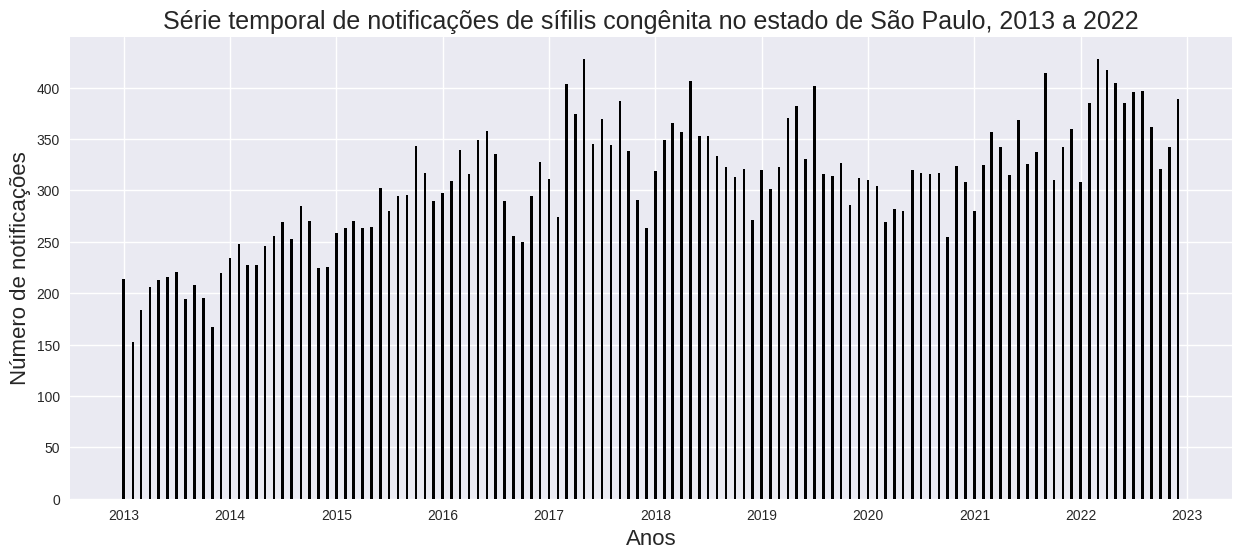

In [24]:
plt.style.use('seaborn')

fig1, ax = plt.subplots(figsize=(15, 6))

#ax.plot(data_set.index, data_set.dengue_cases, color='black', label='Dengue fever cases')
ax.bar(data_set.index, data_set.NOTIFIC, 9, color='#000000', error_kw={'ecolor': '0.3'})

ax.set_title('Série temporal de notificações de sífilis congênita no estado de São Paulo, 2013 a 2022', size=18)
ax.set_xlabel('Anos', size=16)
ax.set_ylabel('Número de notificações', size=16)
ax.legend()

plt.show()

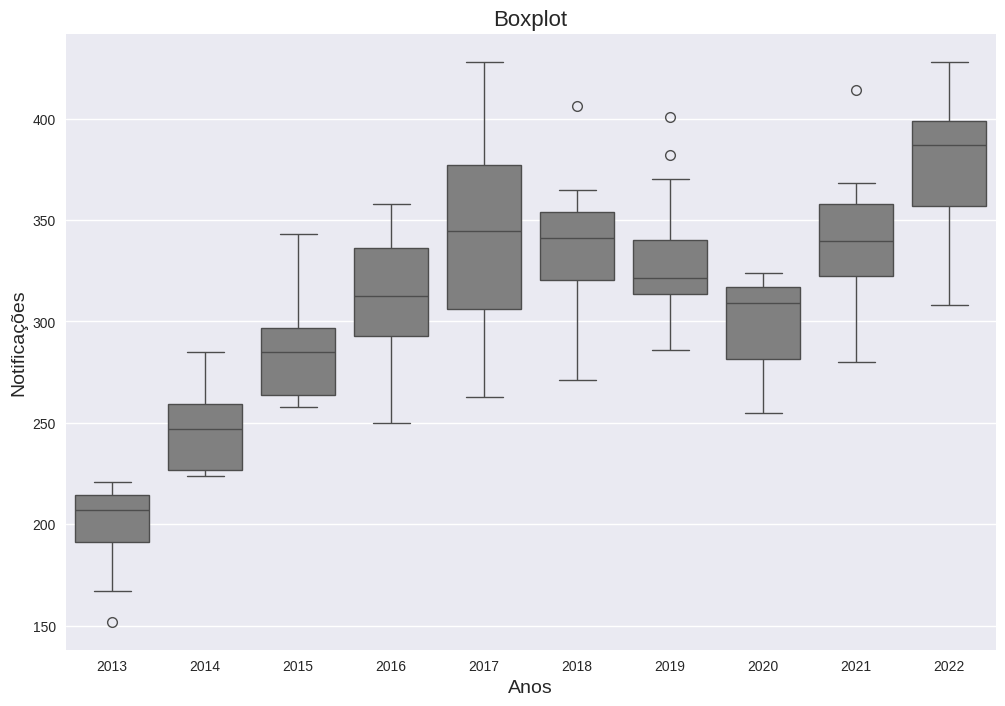

In [25]:
fig2, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x=data_set.index.year, y=data_set.NOTIFIC, ax=ax, color='gray')
ax.set_title('Boxplot', size=16)
ax.set_xlabel('Anos', size=14)
ax.set_ylabel('Notificações', size=14)

plt.show();


In [26]:
mean, w = amplitude_average(data_set.NOTIFIC)
b_0, b_1 = estimate_coef(mean, w)
lr = b_0 + b_1 * mean

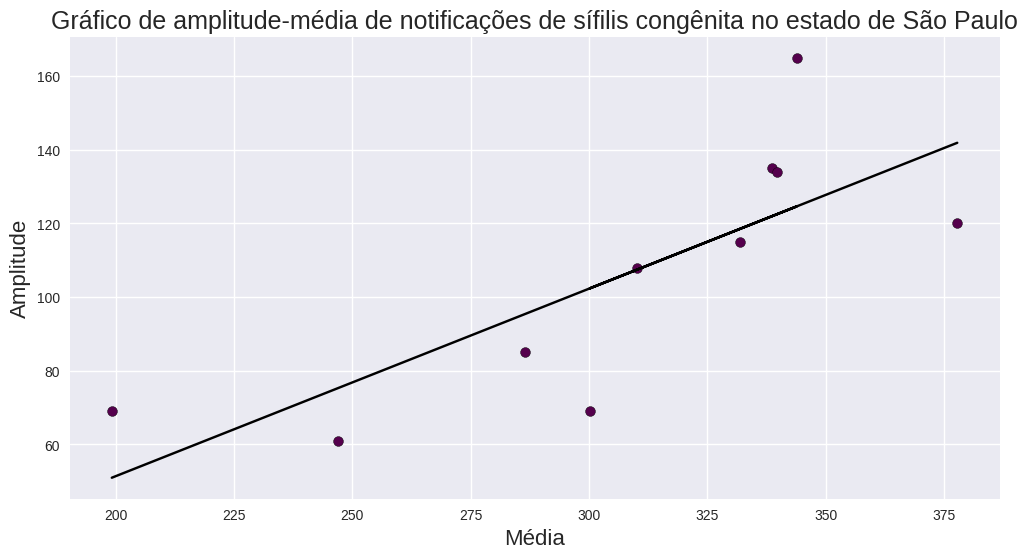

In [27]:
fig4, ax = plt.subplots(figsize=(12, 6))

ax.scatter(mean, w, s=50, edgecolor='black', c='#55004D')
ax.plot(mean, lr, color='#000000')
ax.set_title('Gráfico de amplitude-média de notificações de sífilis congênita no estado de São Paulo', size=18)
ax.set_xlabel('Média', size=16)
ax.set_ylabel('Amplitude', size=16)

plt.show();

In [28]:
data_set['sifc_log'] = log_scale(data_set.NOTIFIC)
moving_avg = data_set.sifc_log.ewm(span=12).mean()
display(data_set)

,NOTIFIC,sifc_log
MES_ANO,,
2013-01-01,214,5.370638
2013-02-01,152,5.030438
2013-03-01,184,5.220356
2013-04-01,206,5.332719
2013-05-01,213,5.365976
...,...,...
2022-08-01,397,5.986452
2022-09-01,362,5.894403
2022-10-01,321,5.774552


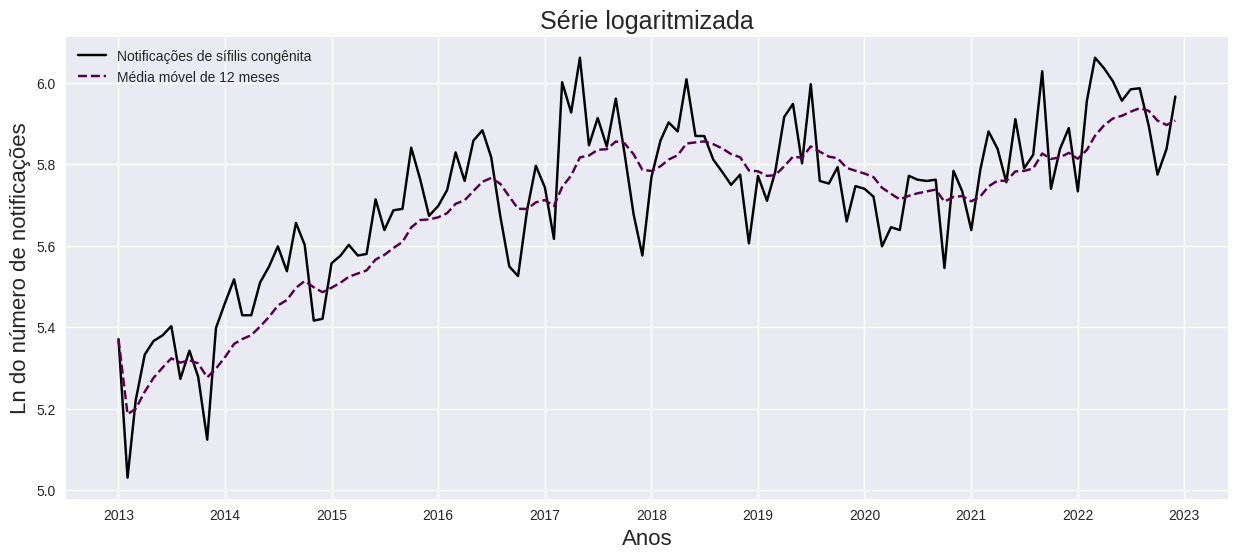

In [29]:
fig6, ax = plt.subplots(figsize=(15, 6))

ax.plot(data_set.sifc_log.index, data_set.sifc_log, color='black', label='Notificações de sífilis congênita')
ax.plot(data_set.sifc_log.index, moving_avg, color='#55004D', linestyle='--', label='Média móvel de 12 meses')

ax.set_title('Série logaritmizada', size=18)
ax.set_xlabel('Anos', size=16)
ax.set_ylabel('Ln do número de notificações', size=16)
ax.legend()

plt.show()

In [30]:
print(test_stationarity(data_set.sifc_log))

Results of Dickey-Fuller Test:
Test Statistic                  -2.716576
p-value                          0.071213
#Lags Used                      11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64
None


In [31]:
print(cox_stuart(data_set.sifc_log))

   fall: 9
   rise: 51
p-value: 3.085035609438902e-08
  trend: Increasing
None


In [ ]:
print(kruskal_wallis(data_set.sifc_log))

p-value:0.0857251214840536
No seasonal
None


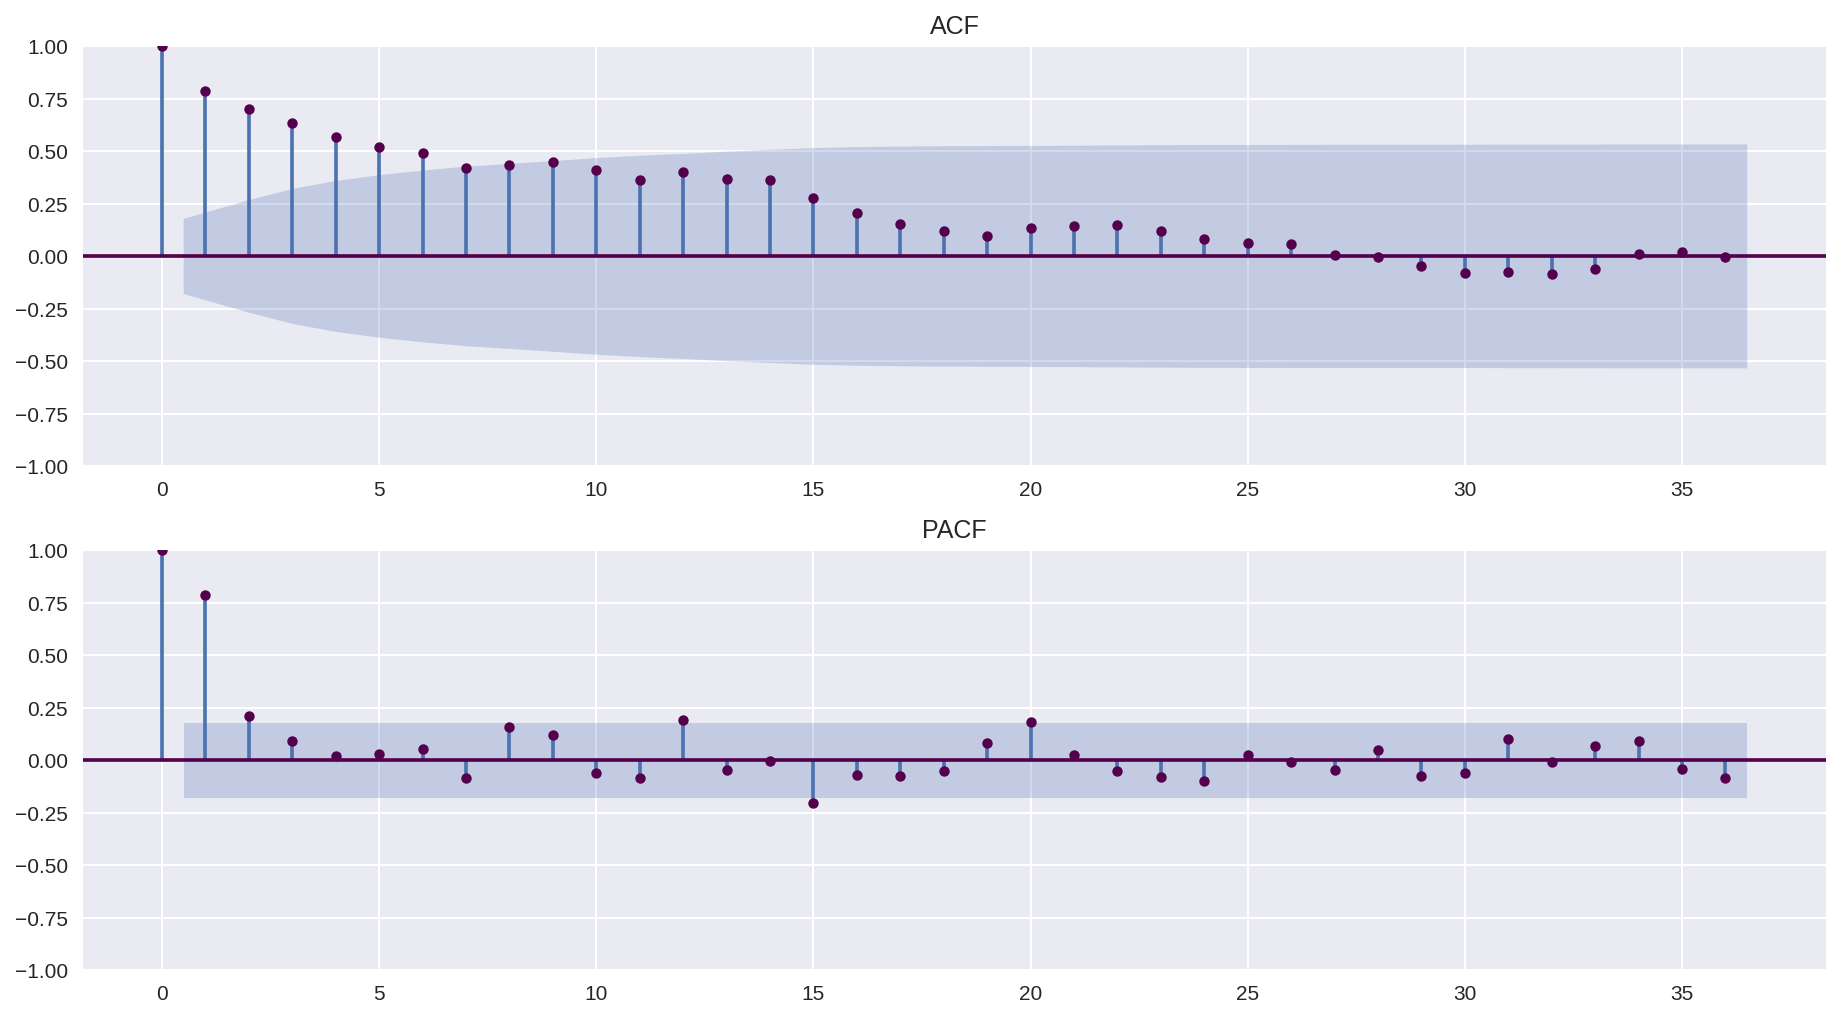

In [ ]:
import statsmodels.api as sm
title = ['ACF', 'PACF']
acf_pacf(data_set.NOTIFIC, 36, title, '#55004D')

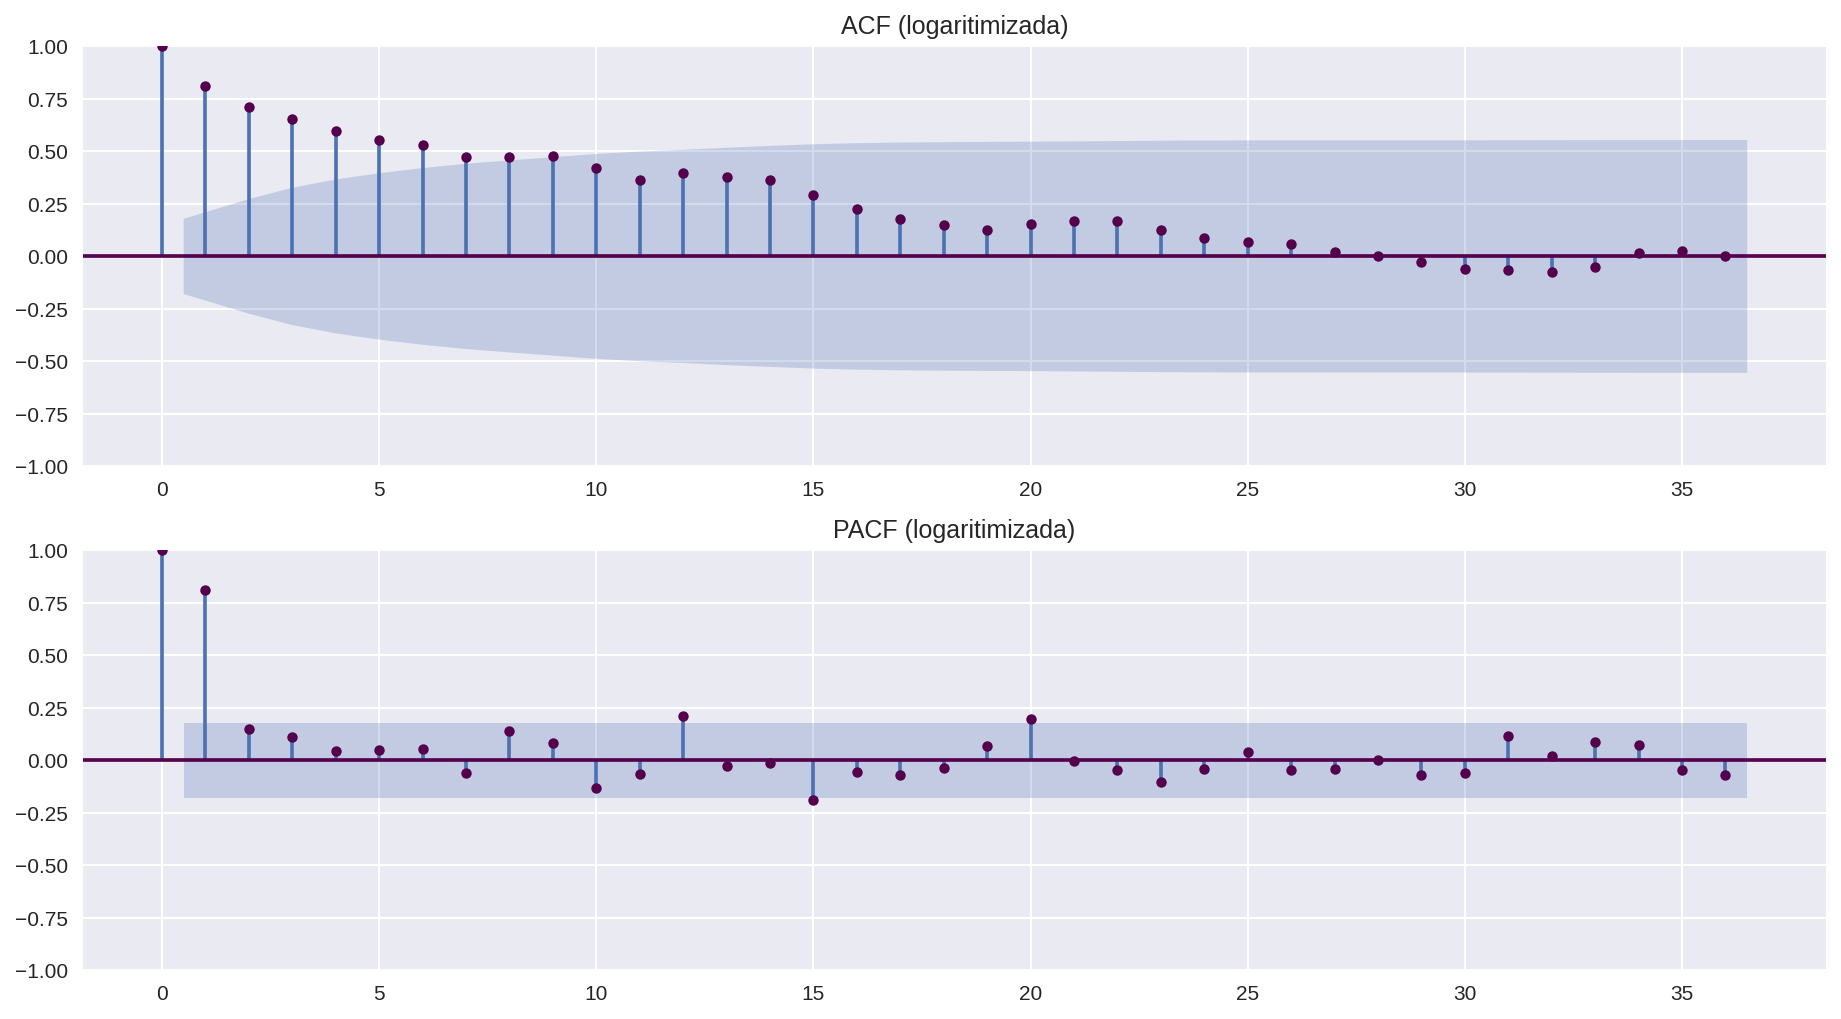

In [ ]:
title = ['ACF (logaritimizada)', 'PACF (logaritimizada)']
acf_pacf(data_set.sifc_log, 36, title, '#55004D')